In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime as dt
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import time
import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score,accuracy_score
from sklearn import metrics
import gc
import dask.dataframe as dd
import dask
import timeit
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sn
#plt.style.use('ggplot')

# This notebook contains EDA to support the binary and frequency encoding

In [2]:
dtypes = {
    'MachineIdentifier':                                    'object',
    'ProductName':                                          'object',
    'EngineVersion':                                        'object',
    'AppVersion':                                           'object',
    'AvSigVersion':                                         'object',
    'IsBeta':                                               'int8',
    'RtpStateBitfield':                                     'float16',
    'IsSxsPassiveMode':                                     'int8',
    'DefaultBrowsersIdentifier':                            'float32',  # was 'float16'
    'AVProductStatesIdentifier':                            'float32',
    'AVProductsInstalled':                                  'float16',
    'AVProductsEnabled':                                    'float16',
    'HasTpm':                                               'int8',
    'CountryIdentifier':                                    'int16',
    'CityIdentifier':                                       'float32',
    'OrganizationIdentifier':                               'float16',
    'GeoNameIdentifier':                                    'float16',
    'LocaleEnglishNameIdentifier':                          'int16',  # was 'int8'
    'Platform':                                             'object',
    'Processor':                                            'object',
    'OsVer':                                                'object',
    'OsBuild':                                              'int16',
    'OsSuite':                                              'int16',
    'OsPlatformSubRelease':                                 'object',
    'OsBuildLab':                                           'object',
    'SkuEdition':                                           'object',
    'IsProtected':                                          'float16',
    'AutoSampleOptIn':                                      'int8',
    'PuaMode':                                              'object',
    'SMode':                                                'float16',
    'IeVerIdentifier':                                      'float16',
    'SmartScreen':                                          'object',
    'Firewall':                                             'float16',
    'UacLuaenable':                                         'float64', # was 'float32'
    'Census_MDC2FormFactor':                                'object',
    'Census_DeviceFamily':                                  'object',
    'Census_OEMNameIdentifier':                             'float32', # was 'float16'
    'Census_OEMModelIdentifier':                            'float32',
    'Census_ProcessorCoreCount':                            'float16',
    'Census_ProcessorManufacturerIdentifier':               'float16',
    'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
    'Census_ProcessorClass':                                'object',
    'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
    'Census_PrimaryDiskTypeName':                           'object',
    'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
    'Census_HasOpticalDiskDrive':                           'int8',
    'Census_TotalPhysicalRAM':                              'float32',
    'Census_ChassisTypeName':                               'object',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
    'Census_PowerPlatformRoleName':                         'object',
    'Census_InternalBatteryType':                           'object',
    'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
    'Census_OSVersion':                                     'object',
    'Census_OSArchitecture':                                'object',
    'Census_OSBranch':                                      'object',
    'Census_OSBuildNumber':                                 'int16',
    'Census_OSBuildRevision':                               'int32',
    'Census_OSEdition':                                     'object',
    'Census_OSSkuName':                                     'object',
    'Census_OSInstallTypeName':                             'object',
    'Census_OSInstallLanguageIdentifier':                   'float16',
    'Census_OSUILocaleIdentifier':                          'int16',
    'Census_OSWUAutoUpdateOptionsName':                     'object',
    'Census_IsPortableOperatingSystem':                     'int8',
    'Census_GenuineStateName':                              'object',
    'Census_ActivationChannel':                             'object',
    'Census_IsFlightingInternal':                           'float16',
    'Census_IsFlightsDisabled':                             'float16',
    'Census_FlightRing':                                    'object',
    'Census_ThresholdOptIn':                                'float16',
    'Census_FirmwareManufacturerIdentifier':                'float16',
    'Census_FirmwareVersionIdentifier':                     'float32',
    'Census_IsSecureBootEnabled':                           'int8',
    'Census_IsWIMBootEnabled':                              'float16',
    'Census_IsVirtualDevice':                               'float16',
    'Census_IsTouchEnabled':                                'int8',
    'Census_IsPenCapable':                                  'int8',
    'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
    'Wdft_IsGamer':                                         'float16',
    'Wdft_RegionIdentifier':                                'float16',
    'HasDetections':                                        'float32',
}



In [3]:
%%time
df_train = dd.read_csv("train.csv", blocksize= 256e6, dtype = dtypes)
gc.collect()
df_train = df_train.compute()
df_train.drop(['index','Date','YearMonth'],axis=1,inplace=True) 

Wall time: 43 s


In [97]:
def encode_categorical(x_train, x_test, columns, sort=True):
    """
    """
    train_length = x_train.shape[0]
    for col in tqdm(columns):
        if col != 'MachineIdentifier' and col != 'HasDetections':
            combined_data = pd.concat([x_train[col], x_test[col]])
            combined_data, _ = pd.factorize(combined_data, sort=sort)
            combined_data = pd.Series(combined_data).astype('int32')
            x_train[col] = combined_data.iloc[:train_length].values
            x_test[col] = combined_data.iloc[train_length:].values
            x_train[col] = x_train[col].fillna(0)
            x_test[col] = x_test[col].fillna(0)
            del combined_data

    return x_train, x_test

In [100]:
g = df_train.columns.to_series().groupby(df_train.dtypes).groups
types_ = {k.name: v for k, v in g.items()}
object_columns = types_['object']

df_train, df_test = encode_categorical(df_train, df_train, object_columns)

## Binary plot

In [6]:
di = {"Off": "off", "On": "on","&#x01;":"1","requireadmin":"RequireAdmin","prompt":"Prompt","&#x02;":"2"}

In [7]:
df_train = df_train.replace({"SmartScreen": di})

In [8]:
freq_ = df_train['SmartScreen'].value_counts()
freq_ = freq_.to_dict()

In [9]:
groupby_ = pd.DataFrame({'count' : df_train.groupby( [ "SmartScreen", "HasDetections"] ).size()}).reset_index()

In [10]:
groupby_

,SmartScreen,HasDetections,count
0,0,1.0,1
1,1,0.0,44
2,1,1.0,47
3,2,0.0,33
4,2,1.0,63
5,Block,0.0,2551
6,Block,1.0,2884
7,ExistsNotSet,0.0,55336
8,ExistsNotSet,1.0,238922
9,Prompt,0.0,4342


In [11]:
groupby_ = groupby_[groupby_.SmartScreen != '0']


In [12]:
sum_ = np.asanyarray(groupby_['count'])

In [16]:
sum_.sum()
keep = ['ExistsNotSet','RequireAdmin','Warn','off','Prompt']

In [17]:
df = groupby_.loc[:, groupby_.columns.str.contains('|'.join(keep))]

In [18]:
filtered = groupby_[groupby_['SmartScreen'].isin(keep)]

In [19]:
filtered_sum_ = np.asanyarray(filtered['count'])

In [20]:
filtered_sum_.sum()

1487946

In [21]:
1487946/1493764

0.9961051411066273

In [22]:
dict_ = {}
for i in range(1,len(groupby_),2):

    if i == len(groupby_)-1:
        break
    total_ = groupby_.loc[i]['count'] + groupby_.loc[i+1]['count']
    dict_[groupby_['SmartScreen'][i]] = groupby_.loc[i+1]['count']/total_
    print(groupby_['SmartScreen'][i])
    i = i + 2

1
2
Block
ExistsNotSet
Prompt
RequireAdmin
Warn
off


In [23]:
dict_

{'1': 0.5164835164835165,
 '2': 0.65625,
 'Block': 0.5306347746090156,
 'ExistsNotSet': 0.8119473387299581,
 'Prompt': 0.4937623877812755,
 'RequireAdmin': 0.44747498755138726,
 'Warn': 0.5928695176438407,
 'off': 0.4973171853441668}

In [24]:
dict_ = {i:dict_[i] for i in keep}

In [25]:
dict_

{'ExistsNotSet': 0.8119473387299581,
 'RequireAdmin': 0.44747498755138726,
 'Warn': 0.5928695176438407,
 'off': 0.4973171853441668,
 'Prompt': 0.4937623877812755}

In [26]:
dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda x: x[1])}

In [27]:
dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda x: x[1])}
x =list(dict_.keys())
y =list(dict_.values())

Not all values are presented, this represent 96%


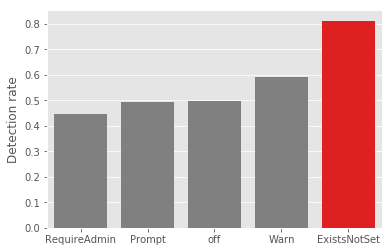

In [96]:
clrs = ['grey' if (x_ < max(y)) else 'red' for x_ in y ]

ax = sns.barplot(x=x, y=y,palette=clrs)
ax.set(ylabel='Detection rate')
print("Not all values are presented, this represent 96%")

In [40]:
c_ = ['CountryIdentifier','Census_OSWUAutoUpdateOptionsName','Census_MDC2FormFactor']

## Census_MDC2FormFactor

In [43]:
groupby_ = pd.DataFrame({'count' : df_train.groupby( [ 'Census_MDC2FormFactor', "HasDetections"] ).size()}).reset_index()
groupby_

,Census_MDC2FormFactor,HasDetections,count
0,AllInOne,0.0,34890
1,AllInOne,1.0,39160
2,Convertible,0.0,49641
3,Convertible,1.0,52259
4,Desktop,0.0,218543
5,Desktop,1.0,251534
6,Detachable,0.0,43908
7,Detachable,1.0,28742
8,IoTOther,0.0,1
9,LargeServer,0.0,138


In [45]:
for i in range(0,len(groupby_),2):

    if i == len(groupby_)-1:
        break
    total_ = groupby_.loc[i]['count'] + groupby_.loc[i+1]['count']
    dict_[groupby_['Census_MDC2FormFactor'][i]] = groupby_.loc[i+1]['count']/total_
    print(groupby_['Census_MDC2FormFactor'][i])
    i = i + 2

AllInOne
Convertible
Desktop
Detachable
IoTOther
LargeServer
LargeTablet
MediumServer
Notebook
PCOther
ServerOther
SmallServer


In [46]:
dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda x: x[1])}
x =list(dict_.keys())
y =list(dict_.values())

In [56]:
min(y) >= y[0]

True

In [59]:
y.remove(min(y))

[Text(0,0.5,'Detection rate')]

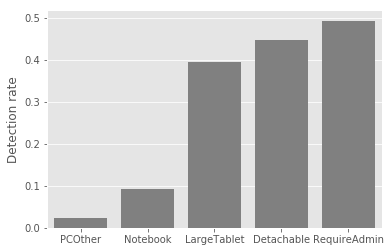

In [60]:
clrs = ['grey' if (x_ >= min(y)) else 'red' for x_ in y ]

ax = sns.barplot(x=x[:5], y=y[:5],palette=clrs)
ax.set(ylabel='Detection rate')


## CountryIdentifier

In [62]:
groupby_ = pd.DataFrame({'count' : df_train.groupby( [ 'CountryIdentifier', "HasDetections"] ).size()}).reset_index()
groupby_

,CountryIdentifier,HasDetections,count
0,1,0.0,249
1,1,1.0,224
2,2,0.0,8366
3,2,1.0,7437
4,3,0.0,610
5,3,1.0,624
6,4,0.0,316
7,4,1.0,197
8,5,0.0,52
9,5,1.0,44


In [64]:
for i in range(0,len(groupby_),2):

    if i == len(groupby_)-1:
        break
    total_ = groupby_.loc[i]['count'] + groupby_.loc[i+1]['count']
    dict_[groupby_['CountryIdentifier'][i]] = groupby_.loc[i+1]['count']/total_
    i = i + 2

In [65]:
dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda x: x[1])}
x =list(dict_.keys())
y =list(dict_.values())

[Text(0,0.5,'Detection rate')]

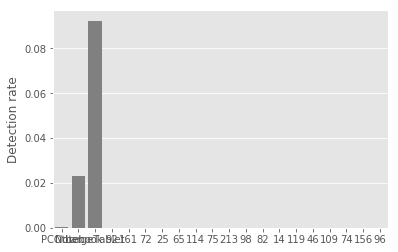

In [68]:
clrs = ['grey' if (x_ >= min(y)) else 'red' for x_ in y ]

ax = sns.barplot(x=x[:20], y=y[:20],palette=clrs)
ax.set(ylabel='Detection rate')


[Text(0,0.5,'Detection rate')]

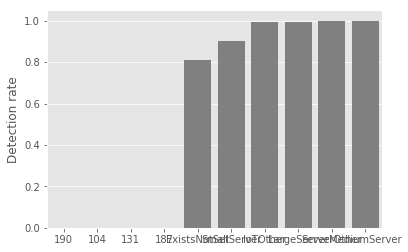

In [70]:
clrs = ['grey' if (x_ >= min(y)) else 'red' for x_ in y ]

ax = sns.barplot(x=x[-10:], y=y[-10:],palette=clrs)
ax.set(ylabel='Detection rate')


## Census_OSWUAutoUpdateOptionsName

In [71]:
groupby_ = pd.DataFrame({'count' : df_train.groupby( [ 'Census_OSWUAutoUpdateOptionsName', "HasDetections"] ).size()}).reset_index()
groupby_

,Census_OSWUAutoUpdateOptionsName,HasDetections,count
0,AutoInstallAndRebootAtMaintenanceTime,0.0,45732
1,AutoInstallAndRebootAtMaintenanceTime,1.0,48767
2,DownloadNotify,0.0,2023
3,DownloadNotify,1.0,1205
4,FullAuto,0.0,415859
5,FullAuto,1.0,486739
6,Notify,0.0,294146
7,Notify,1.0,275142
8,Off,0.0,3562
9,Off,1.0,3367


In [73]:
for i in range(0,len(groupby_),2):

    if i == len(groupby_)-1:
        break
    total_ = groupby_.loc[i]['count'] + groupby_.loc[i+1]['count']
    dict_[groupby_['Census_OSWUAutoUpdateOptionsName'][i]] = groupby_.loc[i+1]['count']/total_
    i = i + 2

In [74]:
dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda x: x[1])}
x =list(dict_.keys())
y =list(dict_.values())

[Text(0,0.5,'Detection rate')]

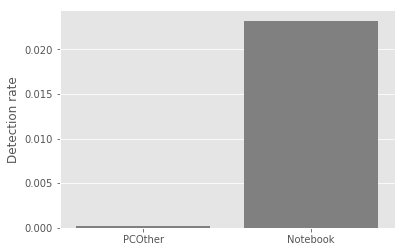

In [77]:
clrs = ['grey' if (x_ >= min(y)) else 'red' for x_ in y ]

ax = sns.barplot(x=x[:2], y=y[:2],palette=clrs)
ax.set(ylabel='Detection rate')


# Freq encoding

## AVProductInstalled

In [19]:
groupby_AV = pd.DataFrame({'count' : df_train.groupby( [ "AVProductsInstalled", "HasDetections"] ).size()}).reset_index()

In [20]:
groupby_AV = groupby_AV[groupby_AV.AVProductsInstalled != 0.0]

In [21]:
sum_AV = np.asanyarray(groupby_AV['count'])
sum_AV = sum_AV.sum()

In [22]:
groupby_AV

,AVProductsInstalled,HasDetections,count
1,1.0,0.0,674114
2,1.0,1.0,863990
3,2.0,0.0,371884
4,2.0,1.0,255528
5,3.0,0.0,37672
6,3.0,1.0,15562
7,4.0,0.0,1705
8,4.0,1.0,625
9,5.0,0.0,93
10,5.0,1.0,31


In [23]:
dict_rate = {}
dict_percentage = {}

for i in range(1,len(groupby_AV),2):

    if i == len(groupby_AV)-1:
        break
    total_ = groupby_AV.loc[i]['count'] + groupby_AV.loc[i+1]['count']
    dict_rate[groupby_AV['AVProductsInstalled'][i]] = groupby_AV.loc[i+1]['count']/total_
    dict_percentage[groupby_AV['AVProductsInstalled'][i]] = total_/sum_AV


In [24]:
dict_rate

{1.0: 0.5617240446679809,
 2.0: 0.40727305183834545,
 3.0: 0.2923319682909419,
 4.0: 0.26824034334763946,
 5.0: 0.25}

In [25]:
dict_percentage

{1.0: 0.6924634635418777,
 2.0: 0.2824645710483404,
 3.0: 0.023966259770593093,
 4.0: 0.0010489796984160856,
 5.0: 5.582552901441829e-05}

In [26]:
x_rate =list(dict_rate.keys())
y_rate =list(dict_rate.values())

x_per =list(dict_percentage.keys())
y_per =list(dict_percentage.values())

In [27]:
x = [int(x_) for x_ in x_per]

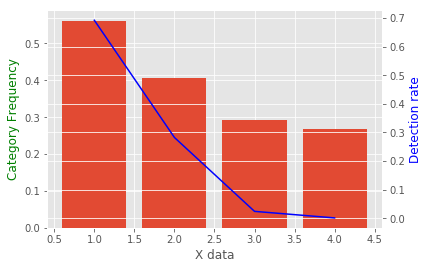

In [28]:

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x[:4], y_rate[:4])
ax2.plot(x[:4], y_per[:4], 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Category Frequency', color='g')
ax2.set_ylabel('Detection rate', color='b')
plt.show()

In [79]:
c_ =['AVProductsInstalled',  'Census_OSInstallTypeName', 'OsBuild', 'EngineVersion',  'OsPlatformSubRelease', 
     'Census_OSBuildNumber','Census_OSBuildRevision',   'Census_FlightRing',  'Census_FirmwareManufacturerIdentifier', 'Wdft_RegionIdentifier']

## OsBuild

In [81]:
groupby_AV = pd.DataFrame({'count' : df_train.groupby( [ "OsBuild", "HasDetections"] ).size()}).reset_index()


## Census_OSBuildRevision

In [87]:
groupby_AV = pd.DataFrame({'count' : df_train.groupby( [ "Census_OSBuildRevision", "HasDetections"] ).size()}).reset_index()

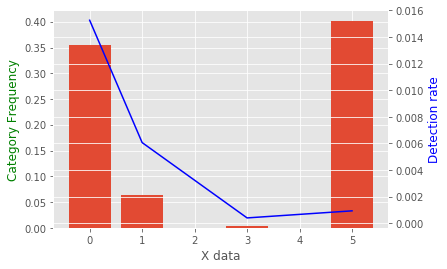

In [89]:
sum_AV = np.asanyarray(groupby_AV['count'])
sum_AV = sum_AV.sum()

dict_rate = {}
dict_percentage = {}

for i in range(1,len(groupby_AV),2):

    if i == len(groupby_AV)-1:
        break
    total_ = groupby_AV.loc[i]['count'] + groupby_AV.loc[i+1]['count']
    dict_rate[groupby_AV['Census_OSBuildRevision'][i]] = groupby_AV.loc[i+1]['count']/total_
    dict_percentage[groupby_AV['Census_OSBuildRevision'][i]] = total_/sum_AV
    
x_rate =list(dict_rate.keys())
y_rate =list(dict_rate.values())

x_per =list(dict_percentage.keys())
y_per =list(dict_percentage.values())

x = [int(x_) for x_ in x_per]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x[:4], y_rate[:4])
ax2.plot(x[:4], y_per[:4], 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Category Frequency', color='g')
ax2.set_ylabel('Detection rate', color='b')
plt.show()

In [4]:
## CountryIdentifier

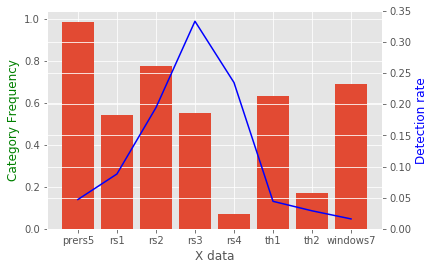

In [13]:
cant = 50
groupby_AV = pd.DataFrame({'count' : df_train.groupby( ['OsPlatformSubRelease', "HasDetections"] ).size()}).reset_index()
sum_AV = np.asanyarray(groupby_AV['count'])
sum_AV = sum_AV.sum()

dict_rate = {}
dict_percentage = {}

for i in range(1,len(groupby_AV),2):

    if i == len(groupby_AV)-1:
        break
    total_ = groupby_AV.loc[i]['count'] + groupby_AV.loc[i+1]['count']
    dict_rate[groupby_AV['OsPlatformSubRelease'][i]] = groupby_AV.loc[i+1]['count']/total_
    dict_percentage[groupby_AV['OsPlatformSubRelease'][i]] = total_/sum_AV
    
x_rate =list(dict_rate.keys())
y_rate =list(dict_rate.values())

x_per =list(dict_percentage.keys())
y_per =list(dict_percentage.values())

#x = [int(x_) for x_ in x_per]
x = x_per
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x[:cant], y_rate[:cant])
ax2.plot(x[:cant], y_per[:cant], 'b-')

ax1.set_xlabel('X data')
ax1.set_ylabel('Category Frequency', color='g')
ax2.set_ylabel('Detection rate', color='b')
plt.show()

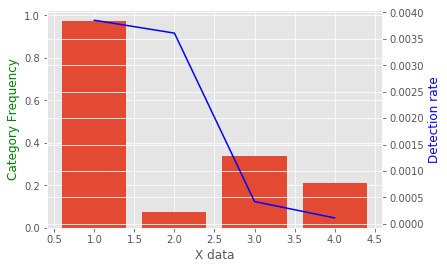

In [6]:
fre_plot('CountryIdentifier')

In [5]:
def fre_plot(cat,cant = 4):
    groupby_AV = pd.DataFrame({'count' : df_train.groupby( [cat, "HasDetections"] ).size()}).reset_index()
    sum_AV = np.asanyarray(groupby_AV['count'])
    sum_AV = sum_AV.sum()
    
    dict_rate = {}
    dict_percentage = {}
    
    for i in range(1,len(groupby_AV),2):
    
        if i == len(groupby_AV)-1:
            break
        total_ = groupby_AV.loc[i]['count'] + groupby_AV.loc[i+1]['count']
        dict_rate[groupby_AV[cat][i]] = groupby_AV.loc[i+1]['count']/total_
        dict_percentage[groupby_AV[cat][i]] = total_/sum_AV
        
    x_rate =list(dict_rate.keys())
    y_rate =list(dict_rate.values())
    
    x_per =list(dict_percentage.keys())
    y_per =list(dict_percentage.values())
    
    x = [int(x_) for x_ in x_per]
    
    fig, ax1 = plt.subplots()
    
    ax2 = ax1.twinx()
    ax1.bar(x[:cant], y_rate[:cant])
    ax2.plot(x[:cant], y_per[:cant], 'b-')
    
    ax1.set_xlabel('X data')
    ax1.set_ylabel('Category Frequency', color='g')
    ax2.set_ylabel('Detection rate', color='b')
    plt.show()

## Census_FlightRing

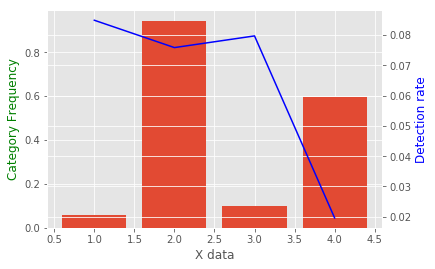

In [94]:
fre_plot('Wdft_RegionIdentifier')

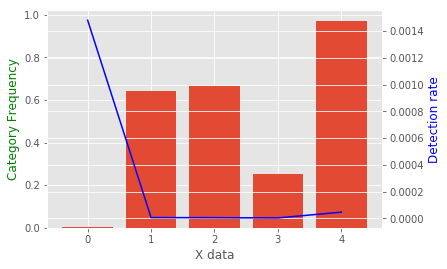

In [125]:
fre_plot('Census_OSVersion',5)

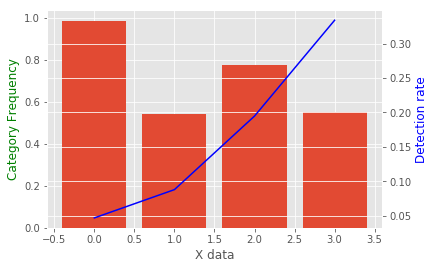

In [102]:
fre_plot('OsPlatformSubRelease')

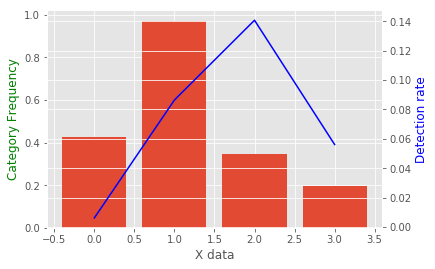

In [105]:
fre_plot('Census_OSInstallTypeName')

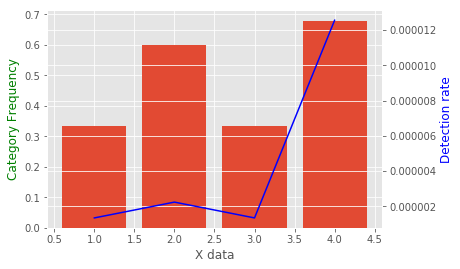

In [114]:
fre_plot('EngineVersion',cant=4)

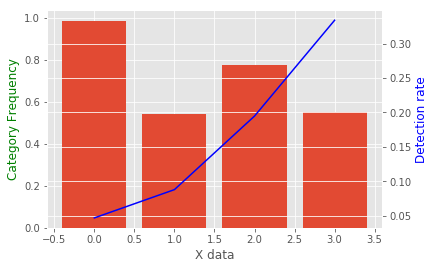

In [112]:
fre_plot('OsPlatformSubRelease',cant=4)

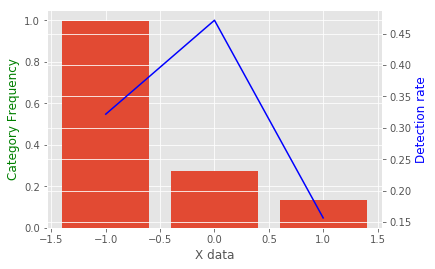

In [121]:
fre_plot('Census_PrimaryDiskTypeName',3)

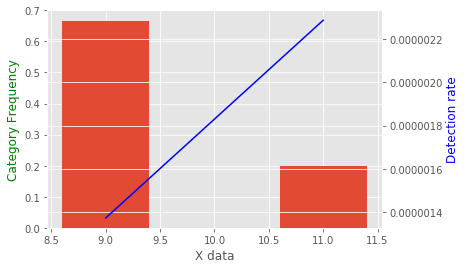

In [127]:
fre_plot('Census_FirmwareManufacturerIdentifier',2)